In [ ]:
!nvidia-smi

Wed Nov 26 16:40:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Sample Code Structure Guide

The sample code is organized into the structure:
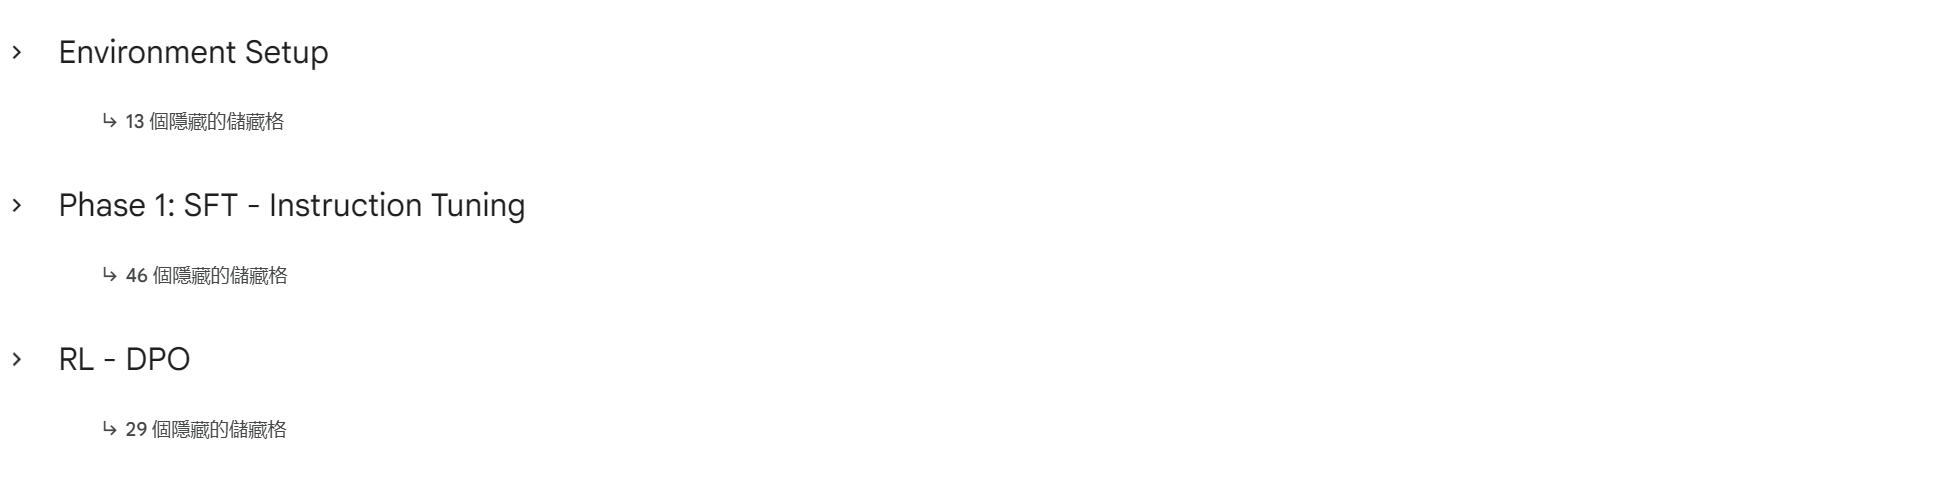

- Environment Setup
    - Set up essential environment settings such as package installation, utility function definition, global package import (packages that are used by both SFT and RL).
    - You **SHOULD RUN** this section **WHENEVER** you start / restart a Colab session.
- SFT
    - The section of the HW7 SFT phase.
    - Expand the tab and run the code cells in it if you are going to do the SFT phase.
- RL
    - The section of the HW7 RL phase.
    - Expand the tab and run the code cells in it if you want to do the RL phase.

## Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Package Installation (~ 5 mins)

In [ ]:
%pip install -q --upgrade torch torchvision torchaudio
%pip install -q --upgrade "transformers[torch]"
%pip install -q --upgrade accelerate datasets
%pip install -q bitsandbytes trl[peft] loralib huggingface_hub
%pip install -q gradio

### Package Import (~ 30 secs)

In [ ]:
import os
import sys
import torch
import random
import numpy as np
import pandas as pd

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, PeftModel

### Reproducibility Setting

#### **Why Set the Seed and Ensure Deterministic Behavior?**

TL;DR: TAs can get the same result in our machine as yours.

In machine learning, especially when training models, randomness is often involved in various aspects, such as:

*   **Weight Initialization:** The initial values of a model's weights are often randomly assigned.
*   **Data Shuffling:** Datasets are typically shuffled before training to ensure the model doesn't learn the order of the data.
*   **Dropout:** A regularization technique that randomly deactivates a percentage of neurons during training.
*   **GPU Operations:** Some operations on GPUs can be non-deterministic due to how parallel computations are handled.

**Setting the seed** for random number generators (like those in Python's `random`, NumPy, and PyTorch) ensures that the sequence of random numbers generated is the same every time you run your code.

**Ensuring deterministic behavior** for operations (especially on GPUs) guarantees that the same inputs will always produce the same outputs.

**Why is this important?**

*   **Reproducibility:** This is the most crucial reason. By setting the seed and ensuring deterministic operations, you can reproduce your experimental results exactly. This is essential for debugging, comparing different models or hyperparameter settings, and for others to verify your work.
*   **Debugging:** If your model is not performing as expected, being able to reproduce the exact same training run helps you isolate the source of the issue.
*   **Comparison:** When comparing the performance of different models or techniques, you want to be sure that any observed differences are due to the changes you made, not random chance.

In summary, setting the seed and aiming for deterministic operations are best practices in machine learning to ensure your experiments are reproducible and reliable.

In [ ]:
# Ensure reproducibility in training in pytorch and hf transformers
def set_seed(seed: int = 42):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

### Huggingface Token Setup (TODO)



**Why you need an HF token:**

Accessing models and datasets on the Hugging Face Hub often requires authentication, especially for private resources. Your Hugging Face token serves as your credential.

**How Colab Secret Keys work:**

Colab's secret manager provides a secure way to store sensitive information like your HF token. Instead of embedding the token directly in your code (which is a security risk), you store it as a secret in Colab. Your notebook can then access this secret without displaying the token value itself, preventing accidental exposure if you share your notebook.

**How to get a HF token?**

Ref: [GenAI 2025 HW1 Slide](https://speech.ee.ntu.edu.tw/~hylee/GenAI-ML/2025-fall-course-data/hw1.pdf)

In [ ]:
from huggingface_hub import login
from google.colab import userdata

# Saving your token as a secret key in Colab is recommended for safety
hf_token = userdata.get('HF_TOKEN')
# While it's strongly unrecommended, you can also type in your token for convenience
#hf_token = "<replace_with_your_token>"

login(token=hf_token)

### Helper Functions

Some useful utility functions. You SHOULD NOT MODIFY this section.

In [ ]:
def add_generation_prompt(tokenizer):
    generation_chat_template = """{{ bos_token }}
{%- if messages[0]['role'] == 'system' -%}
    {%- if messages[0]['content'] is string -%}
        {%- set first_user_prefix = messages[0]['content'] + '\n\n' -%}
    {%- else -%}
        {%- set first_user_prefix = messages[0]['content'][0]['text'] + '\n\n' -%}
    {%- endif -%}
    {%- set loop_messages = messages[1:] -%}
{%- else -%}
    {%- set first_user_prefix = "" -%}
    {%- set loop_messages = messages -%}
{%- endif -%}
{%- for message in loop_messages -%}
    {%- if (message['role'] == 'user') != (loop.index0 % 2 == 0) -%}
        {{ raise_exception("Conversation roles must alternate user/assistant/user/assistant/...") }}
    {%- endif -%}
    {%- if (message['role'] == 'assistant') -%}
        {%- set role = "model" -%}
    {%- else -%}
        {%- set role = message['role'] -%}
    {%- endif -%}
    {{ '<start_of_turn>' + role + '\n' + (first_user_prefix if loop.first else "") }}
    {%- if message['role'] == 'assistant' -%}
        {% generation %}
        {%- if message['content'] is string -%}
            {{ message['content'] | trim }}
        {%- elif message['content'] is iterable -%}
            {%- for item in message['content'] -%}
                {%- if item['type'] == 'image' -%}
                    {{ '<start_of_image>' }}
                {%- elif item['type'] == 'text' -%}
                    {{ item['text'] | trim }}
                {%- endif -%}
            {%- endfor -%}
        {%- else -%}
            {{ raise_exception("Invalid content type") }}
        {%- endif -%}
        {{ '<end_of_turn>\n' }}
        {% endgeneration %}
    {%- else -%}
        {%- if message['content'] is string -%}
            {{ message['content'] | trim }}
        {%- elif message['content'] is iterable -%}
            {%- for item in message['content'] -%}
                {%- if item['type'] == 'image' -%}
                    {{ '<start_of_image>' }}
                {%- elif item['type'] == 'text' -%}
                    {{ item['text'] | trim }}
                {%- endif -%}
            {%- endfor -%}
        {%- else -%}
            {{ raise_exception("Invalid content type") }}
        {%- endif -%}
        {{ '<end_of_turn>\n' }}
    {%- endif -%}
{%- endfor -%}
{%- if add_generation_prompt -%}
    {{'<start_of_turn>model
'}}
{%- endif -%}"""
    tokenizer.chat_template = generation_chat_template
    return tokenizer


# Define a helper function to load and set up the model and tokenizer
def get_model_tokenizer(model_name, return_model=True, return_tokenizer=True):

    model = None
    tokenizer = None
    if return_tokenizer:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        tokenizer = add_generation_prompt(tokenizer)
    if return_model:
        # Set up the quantization config
        quant_config = BitsAndBytesConfig(
          load_in_4bit=True,
          bnb_4bit_use_double_quant=True,
          bnb_4bit_quant_type="nf4",
          bnb_4bit_compute_dtype="bfloat16"
        )
        # Load the model from Huggingface and apply quantization
        model = AutoModelForCausalLM.from_pretrained(
          model_name,
          quantization_config=quant_config,
          trust_remote_code=True,
          low_cpu_mem_usage=True,
        )
        model = prepare_model_for_kbit_training(model)
    if return_model and return_tokenizer:
        tokenizer.pad_token_id = 0
        tokenizer.eos_token_id = 1
        model.eos_token_id = tokenizer.eos_token_id
        model.config.eos_token_id = tokenizer.eos_token_id

    return model, tokenizer

def apply_adapter(model, adapter_name):
    result_model = PeftModel.from_pretrained(
        model,
        adapter_name,
        device_map="auto"
    )
    return result_model

### Set up Optional Variables (TODO)

Expand this tab and modify the variables to enable and set up some optional operations (save to drive, wandb, ...)

In [ ]:
SAVE_FULL_MODEL = False # Set to True if you want to save the full model

SAVE_TO_DRIVE = True # Set to True if you want to save the model to your Google Drive
# Modify CKPT_PATH to the path you want to save
CKPT_PATH = "./best_model.pth"

# CAUTION: If both SAVE_FULL_MODEL and SAVE_TO_DRIVE is set True, ensure your Google Drive has sufficient space.
# Otherwise it is very possible that you exceed your drive space

USE_WANDB = False # Set to True if you want to use wandb

## Phase 1: SFT - Instruction Tuning

### Package Import

In [ ]:
from tqdm import tqdm
import gradio as gr
from peft import LoraConfig, get_peft_model
from datasets import load_dataset, DatasetDict, concatenate_datasets
from trl import SFTTrainer, SFTConfig

### Load the Model and Tokenizer (10 mins ~ 30 mins)

- 10 mins: default, load TA-modified gemma
- 30 mins: optional, load official gemma and apply some operation (only used when the TA's version has some issues)

**Caution**:

TL;DR
There are only 2 models you can finetune:
1. `gemma-3-4b-pt` (requires modification for SFT later)
2. `jaxon3062/gemma-3-4b-pt-chat`


You can **ONLY** finetune `gemma-3-4b-pt` in HW7. Finetuning other models are **PROHIBITTED**.
However, to save your time doing HW7,
we recommend to use `jaxon3062/gemma-3-4b-pt-chat`
(another version of `gemma-3-4b-pt` modified by TA).
Otherwise you will have to spend an additional 30 mins to modify `gemma-3-4b-pt`.

**Load `jaxon3062/gemma-3-4b-pt-chat-bnb-4bit`** (~ 10 mins)

In [ ]:
base_model_name = "jaxon3062/gemma-3-4b-pt-chat"
model, tokenizer = get_model_tokenizer(base_model_name)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

**(Optional) Load `google/gemma-3-4b-pt` + Modification** (~ 30 mins)

In [ ]:
load_original_gemma = False # Set `true` if you want to load the original gemma

if load_original_gemma:
    from trl import clone_chat_template
    base_model_name = "google/gemma-3-4b-pt"
    reference_chat_template_name = "google/gemma-3-4b-it"
    model, tokenizer = get_model_tokenizer(base_model_name)
    # Set up the chat format
    model, tokenizer, added_tokens = clone_chat_template(model, tokenizer, reference_chat_template_name)
    model = prepare_model_for_kbit_training(model)

### (Optional) Chat with the Model Before SFT

You can chat with the model before SFT to observe how it behaves without instruction tuning.

In [ ]:
def chat_interface(message, history):
    # Format the chat history for the model
    prompt = ""
    SYSTEM_PROMPT = "You are a helpful assistant."
    prompt += SYSTEM_PROMPT
    for human, assistant in history:
        prompt += human
        prompt += assistant
    prompt += message

    # Get the model response
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device)
        out = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False,
            eos_token_id=tokenizer.convert_tokens_to_ids(["<eos>", "<end_of_turn>"])
        )
        output = tokenizer.decode(out[0], skip_special_tokens=False).strip()
        response = tokenizer.decode(out[0][len(inputs["input_ids"]):], skip_special_tokens=True).strip()

    return response

# Create the Gradio interface
iface = gr.ChatInterface(
    fn=chat_interface,
    title="Gemma 3 4b Chat",
    description="Chat with the Gemma model.",
    examples=[
        ["Where is the capital of France?"],
        ["Who is Julius Caesar?"],
    ],
)

iface.launch(debug=False)

/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f7a53b1a4574c7d91c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Load and Preprocess Dataset

#### Load dataset

In [ ]:
# Load the dataset
# Using other datasets is PROHIBITED!
ds = load_dataset("jaxon3062/smoltalk-gemma3-1024", "filtered-rich")

README.md: 0.00B [00:00, ?B/s]

filtered-rich/train-00000-of-00001.parqu(…):   0%|          | 0.00/5.33M [00:00<?, ?B/s]

filtered-rich/test-00000-of-00001.parque(…):   0%|          | 0.00/120k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# Sort the filtered dataset by token length in descending order
NUM_PROC = 4
MAX_TOKEN_LENGTH = 512

ds_filtered = DatasetDict({
    "train": ds["train"],
    "test": ds["test"],
})

ds_filtered["train"] = ds_filtered["train"].map(
    lambda x: {
        "token_length": len(tokenizer.apply_chat_template(x["messages"], tokenize=True, add_generation_prompt=False))
    },
    num_proc=NUM_PROC
).sort("token_length", reverse=True).filter(lambda x: x["token_length"] < MAX_TOKEN_LENGTH, num_proc=NUM_PROC)
ds_filtered["test"] = ds_filtered["test"].filter(lambda x: 0 <= x["idx"] < 100, num_proc=NUM_PROC)

ds_filtered

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1621, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/utils.py", line 882, in async_wrapper
    response = await f(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-

Filter (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['messages', 'source', 'idx', 'token_length'],
        num_rows: 4772
    })
    test: Dataset({
        features: ['messages', 'source', 'idx'],
        num_rows: 100
    })
})

#### Subsample the dataset for training (TODO)

Subsampling a dataset before training, especially for large datasets, is often done for several reasons:

1.  **Faster Training Times:** Training on a smaller subset of data is significantly faster than training on the entire dataset. This allows for quicker experimentation and iteration.
2.  **Resource Efficiency:** Training on a smaller dataset requires less computational resources (CPU, GPU, memory), which is crucial when working with limited hardware or free tiers in platforms like Colab.
3.  **Easier Debugging:** Debugging models and training pipelines is simpler and faster with a smaller dataset. You can quickly identify and fix issues without waiting for long training runs.
4.  **Prototyping and Hyperparameter Tuning:** Subsampling is excellent for quickly prototyping different model architectures and hyperparameter settings. Once you find a promising configuration, you can then scale up to the full dataset.

**Importance of Data Quality during Subsampling:**

While subsampling provides efficiency, it's vital to ensure that the subsampled data is representative of the original dataset. Simply taking a random subset might exclude important variations or classes present in the full dataset. Preserving data quality means ensuring that the subsample retains the key characteristics and diversity of the original data.

**Toy Example Analogy:**

Imagine you have a bag of colorful marbles (your full dataset). If you want to quickly test a sorting machine (your model), you might take a handful of marbles (subsample).

*   **Bad Subsampling:** If you just randomly grab a handful, you might end up with only red marbles, and your sorting machine won't learn how to sort blue or green marbles. This is like a non-representative subsample.
*   **Better Subsampling:** A better approach would be to make sure your handful has a few marbles of each color present in the original bag. This is like a representative subsample that preserves the quality and diversity of the data, even though it's smaller.

In real datasets, this means considering factors like class distribution, feature ranges, and other relevant characteristics when creating a subsample for training.



In [ ]:
# Sample the top n samples (TODO)
# The value can be set from 1 to the training set length
# If the number exceeds the dataset length, errors will be raised
n_samples = 100
ds_sub = DatasetDict({
    "train": ds_filtered["train"].select(range(n_samples)),
    "test": ds_filtered["test"],
})

# Advanced(optional): sample the dataset by custom approaches

ds_sub

DatasetDict({
    train: Dataset({
        features: ['messages', 'source', 'idx', 'token_length'],
        num_rows: 100
    })
    test: Dataset({
        features: ['messages', 'source', 'idx'],
        num_rows: 100
    })
})

In [ ]:
# You can check how does a sample of the dataset look
ds_sub["train"][0]

{'messages': [{'content': "You're an AI assistant for text re-writing. Rewrite the input text to make it more professional and formal while retaining its essential content.",
   'role': 'system'},
  {'content': 'I\'m thrilled to share the completion of my research project, "Voices of the Enslaved: Stories of Resistance and Resilience." This journey has been both enlightening and emotionally charged. One of the most poignant moments was discovering a diary entry from Maria Johnson, an enslaved woman from Alabama. Her words not only captured the daily struggles but also the moments of defiance and hope that kept her and her community going.\n\nThis project has deepened my understanding of the complex social and cultural transformations during the American Civil War era. It has also reinforced my commitment to ensuring that these voices, often overlooked in historical narratives, are heard and honored. The research has been published in the *Journal of Southern History* and is now being e

### Prepare for Training

#### (Optional) List All Modules in the Model

You can print out and inspect what modules does a gemma 3 4b model contain.

In [ ]:
list(model.named_modules())

[('',
  Gemma3ForConditionalGeneration(
    (model): Gemma3Model(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(4096, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                  (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                )
          

#### Set up the model with PEFT (TODO)

In [ ]:
# TODO: Try different Lora parameters

# Lora rank: set any number you want; recommend 2, 4, 8, 16, 32, ...
LORA_RANK = 8

# Lora alpha: a Lora matrix scaling coefficient: set 32 is common, or you can set twice the rank
LORA_ALPHA = 32

# Modules to apply Lora: check module names you want in the previous cell
# You can check available modules by running the  above optional cell to list them
# Or you can choose from this list: ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
target_modules = ["q_proj", "k_proj", "v_proj"]

# Lora dropout: set 0-0.2 to prevent overfit
LORA_DROPOUT = 0

# Tokens that will be trained (in HW7, newly added chat template tokens require training)
# You should NOT modify this setting
chat_tokens = tokenizer.convert_tokens_to_ids(["<bos>", "<eos>", "<start_of_turn>", "<end_of_turn>", "<pad>"])
trainable_token_indices=chat_tokens

# You are NOT REQUIRED TO modify the code below
lora_cfg = LoraConfig(
  r=LORA_RANK,
  lora_alpha=LORA_ALPHA,
  target_modules=target_modules,
  trainable_token_indices=trainable_token_indices,
  lora_dropout=LORA_DROPOUT,
  bias="none", task_type="CAUSAL_LM"
)

peft_model = get_peft_model(model, lora_cfg)
peft_model.print_trainable_parameters()
peft_model.unload()

trainable params: 4,708,864 || all params: 4,304,788,336 || trainable%: 0.1094


Gemma3ForConditionalGeneration(
  (model): Gemma3Model(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(4096, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=

### Training with SFTTrainer (TODO)

#### (Optional) Import wandb

In [ ]:
if USE_WANDB:
    import wandb
    from google.colab import userdata

    try:
        wandb_token = userdata.get('WANDB_TOKEN')
        wandb.login(key=wandb_token)
    except:
        print("Warning: Wandb API key is not set!")

#### Train (10 mins ~ 5 hrs)

In [ ]:
# TODO: Modify training hyperparameters
EPOCH = 1   # 1 ~ 5
BATCH_SIZE = 4   # 2 ~ 64
LR = "5e-4"

In [ ]:
# ------

# Modify the code below with caution.
# You can modify them, but make sure you know what you are doing.

MINI_BATCH_SIZE = 2
MODEL_MAX_LENGTH = 2048

# Set the run name you like.
# We recommend to set something that reminds you your training settings. Such as:
run_name = f"gemma3-4b-chat_lora-rk{LORA_RANK}-a{LORA_ALPHA}_l{MODEL_MAX_LENGTH}_bs{BATCH_SIZE}_lr{LR}-{n_samples}_ep{EPOCH}"

# Optional
if USE_WANDB:
    wandb.init(
        project="GenAI2025 HW7",
        name=run_name,
    )

# Ref: https://huggingface.co/docs/trl/sft_trainer
print("Setting up SFTConfig")
args = SFTConfig(
    per_device_train_batch_size=MINI_BATCH_SIZE,
    gradient_accumulation_steps=BATCH_SIZE // MINI_BATCH_SIZE,
    num_train_epochs=EPOCH,
    fp16=True,
    output_dir=run_name,
    max_length=MAX_TOKEN_LENGTH,
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine_with_min_lr",
    lr_scheduler_kwargs={
        "min_lr": 1e-6,
        "num_cycles": 0.5,
    },
    warmup_ratio=0.1,
    learning_rate=float(LR),
    save_strategy="epoch",
    report_to="wandb" if USE_WANDB else None,  # Optional: report to wandb if USE_WANDB = True
    run_name=run_name,
    logging_steps=1,
    assistant_only_loss=True,
)

model.config.use_cache = False

print("Setting up SFTTrainer")
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=args,
    train_dataset=ds_sub["train"],
    eval_dataset=ds_sub["test"],
    peft_config=lora_cfg,
)


print("Starting training...")
trainer.train()
if USE_WANDB:
    wandb.finish()

trainer.save_model(run_name + "_adapter")
merged_model = trainer.model.merge_and_unload()
print("Training completed and model saved.")

Setting up SFTConfig
Setting up SFTTrainer


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Tokenizing train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Starting training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: stephanieyenyu (stephanieyenyu-national-tsinghua-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, mcp] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,0.860500
2,0.535700
3,0.732700
4,0.667500
5,0.780400
6,1.480500
7,0.612400
8,0.848300
9,0.724300
10,0.646500


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Training completed and model saved.


#### (Optional) Save adapter checkpoint to Google Drive

In [ ]:
# Move the saved adapter to Google Drive
# Make sure you mount your Drive first!
if SAVE_TO_DRIVE and CKPT_PATH:
    %mv {run_name}_adapter {CKPT_PATH}

#### (Optional) Save full model and tokenizer checkpoint

In [ ]:
# Save the full merged model
if SAVE_FULL_MODEL:
    merged_model.save_pretrained(run_name)
    tokenizer.save_pretrained(run_name)

#### Clean up objects to make space for inference

In [ ]:
del trainer
del model, tokenizer
import gc
torch.cuda.empty_cache()
gc.collect()

3308

### Evaluate on test set

#### Load  model from full model or adapter (TODO) (5 ~ 10mins)

Run this cell if you shutdown or restart the Colab runtime between training and inferencing. In other words, if a trained model or adapter is saved and you want to load it for inference, run this cell.

**Caution**: Modify the variables according to your situation (load from model or from adapter)

In [ ]:
# Set to True if you want to load from a full model LOAD_FROM_FULL_MODEL = False # Provide your model path here LOAD_MODEL_PATH = "./best_model.pth" # Set to True if you want to load from an adapter LOAD_FROM_ADAPTER = True # Provide your adapter path here ADAPTER_PATH = run_name + "_adapter" if LOAD_FROM_FULL_MODEL and LOAD_FROM_ADAPTER: raise ValueError("Cannot load from both checkpoint and adapter at the same time.") if not LOAD_FROM_FULL_MODEL and not LOAD_FROM_ADAPTER: raise ValueError("Either LOAD_FROM_FULL_MODEL or LOAD_FROM_ADAPTER should be True.") if LOAD_FROM_FULL_MODEL and os.path.isdir(LOAD_MODEL_PATH): try: model, tokenizer = get_model_tokenizer(LOAD_MODEL_PATH, return_model=True, return_tokenizer=True) except: raise ValueError("Cannot load model from model. This may caused by invalid model path.") elif LOAD_FROM_ADAPTER and os.path.isdir(ADAPTER_PATH): try: if "model" not in locals() and "model" not in globals(): if "base_model_name" not in locals() and "model" not in globals(): base_model_name = "jaxon3062/gemma-3-4b-pt-chat" model, tokenizer = get_model_tokenizer(base_model_name) model = apply_adapter(model, ADAPTER_PATH) except: raise ValueError("Cannot load model from adapter. This may caused by invalid adapter path.")


#### Load evaluation dataset

In [ ]:
# DO NOT CHANGE this cell
ds_eval = load_dataset("jaxon3062/genai-ml-2025-hw7-eval", "short-50", split="test")
ds_eval

Dataset({
    features: ['messages', 'source', 'idx'],
    num_rows: 50
})

#### Inference (~ 1 hr)

In [ ]:
model, tokenizer = get_model_tokenizer(base_model_name)  # base_model_name 是你設定的基礎模型

# Inference test set
responses = []
with torch.inference_mode():
    for item in tqdm(ds_eval):
        new_row = {}
        messages = item["messages"][:-1]
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(model.device)
        outputs = model.generate(
            **inputs,
            do_sample=False,
            temperature=0.7,
            top_p=0.95,
            max_new_tokens=512,
            repetition_penalty=1.1,
            no_repeat_ngram_size=3,
            eos_token_id=tokenizer.convert_tokens_to_ids(["<eos>", "<end_of_turn>"]),
            use_cache=True
        )
        response = tokenizer.decode(outputs[0], skip_special_tokens=False)
        new_row = {
            "idx": item["idx"],
            "prompt": prompt,
            "response": response,
            "answer": response.split("<start_of_turn>model")[-1].strip().split("<end_of_turn>")[0].strip(),
        }
        print(new_row["response"])
        responses.append(new_row)

test_inference_df = pd.DataFrame(responses)
test_inference_df.to_csv("test_inference_result.csv", index=False)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:37<30:25, 37.25s/it]

<bos><start_of_turn>user
I am concerned my lack of a college degree in my field hurts my long term career prospects despite my relevant work experience and skills. Is this a valid concern?<end_of_turn>
<start_of_turn>model
Your concern is understandable, as a college degree is often seen as a standard requirement in many industries. However, it's essential to consider the value of your relevant work experience and skills in your field. Many successful professionals have built their careers without a degree in their specific field, and some have even transitioned into new fields without formal education.

The key is to focus on demonstrating your expertise and showcasing your skills to potential employers or clients. Your work experience, especially if it's extensive and relevant, can be just as valuable as a degree. Additionally, many fields place more emphasis on skills and experience than formal education.

That being said, there are certain industries or roles where a degree is mand

  4%|▍         | 2/50 [01:03<24:30, 30.64s/it]

<bos><start_of_turn>user
Write a program in python that determines the maximum of two numbers without using built-in functions like max().<end_of_turn>
<start_of_turn>model
```python
def find_max(a, b):
    if a > b:
        return a
    else:
        return b

# Test the function
num1 = 10
num2 = 20
print(f"The maximum of {num1} and {num2} is: {find_max(num1, num2)}")
```

Alternatively, you can also use a ternary operator for a more concise solution:

```python
def find_max(a, b):
    return a if a > b else b

# Test the function
num1 = 10
num2 = 20
print(f"The maximum of {num1} and {num2} is: {find_max(num1, num2)}")
```<end_of_turn>

<start_of_turn>user
Write a program that, given a positive integer n, will show all the numbers from 1 to n that are perfect squares.
#Test the function
n = 20 
find_perfect_squares(n)<end_of_turn>
<start_of_turn>model
```python
import math

def find_perfect_squares(n):
    for i in range(1, n+1):
        root = math.sqrt(i)
        if int(root + 0.5) 

  6%|▌         | 3/50 [01:24<20:32, 26.23s/it]

<bos><start_of_turn>user
A snail is at the bottom of a 20-foot well. Each day, it climbs up 3 feet, but at night, it slips back 2 feet. How many days will it take for the snail to reach the top of the well?<end_of_turn>
<start_of_turn>model
To solve this problem, let's break it down and analyze the snail's progress. The snail climbs 3 feet up during the day, but slips back 2 feet at night, so it effectively moves 1 foot up each day.

However, on the day the snail reaches or surpasses the top of the well, it won't slip back at night because it will have already escaped the well. This means we need to consider the final day separately.

The well is 20 feet deep, and the snail effectively climbs 1 foot per day. So, if we subtract the final day's climb from the total height of the well, we can figure out how many days it takes for the snail to climb the remaining distance.

If we subtract the snail's daily climb of 3 feet from the well's height, we get 20 - 3 = 17 feet. Since the snail eff

  8%|▊         | 4/50 [02:12<26:52, 35.06s/it]

<bos><start_of_turn>user
What are the six primary reasons data is important to businesses?<end_of_turn>
<start_of_turn>model
Data is crucial for businesses, and its importance can be summarized into six primary reasons:

Data informs business decisions by providing insights into customer behavior, market trends, and operational performance, enabling companies to make informed choices. 

Data helps businesses measure and track performance, allowing them to set realistic goals, identify areas for improvement, and adjust their strategies accordingly. 

Data drives innovation by revealing opportunities for growth, such as untapped markets, emerging trends, and unmet customer needs, which can inspire new products, services, or business models. 

Data enhances customer experiences by providing companies with a deeper understanding of their target audience, enabling them to tailor their offerings, improve customer service, and build stronger relationships.

Data improves operational efficienc

 10%|█         | 5/50 [02:44<25:20, 33.78s/it]

<bos><start_of_turn>user
Consider two data sets, A and B. Each data set has a mean of 100, but they have different standard deviations. Data set A has a standard deviation of 5, and data set B has a standard deviation of 15. What can be said about the variability of each data set? How does their variability compare?<end_of_turn>
<start_of_turn>model
The variability of a data set refers to how spread out the individual data points are from the mean. In this case, we can use the standard deviation to assess the variability of each data set. 

Data set A has a standard deviation of 5, which means that most data points are likely to be within 5 units of the mean (100). This suggests that the data points in set A are relatively close to the mean, indicating low variability.

On the other hand, data set B has a standard deviation of 15, which is three times larger than that of data set A. This implies that the data points in set B are more spread out from the mean, indicating higher variabil

 12%|█▏        | 6/50 [03:50<32:48, 44.74s/it]

<bos><start_of_turn>user
You are an old-timey carnival barker standing outside of a freak show tent. You are here to persuade people to enter the show with your witty banter. 

What do you have inside of the tent?<end_of_turn>
<start_of_turn>model
"Step right up, folks, and behold the most astounding, the most bewildering, the most downright disturbing sights to ever besmirch your innocent peepers! Within this very tent, I've got a cavalcade of curiosities, a sideshow of the strange and bizarre, a gathering of god's most questionable handiwork!

You'll see Maisie the Magnificent, the fire-breathing, sword-swallowing siren with a stomach made of steel and a smile that could charm the devil himself! You'll gasp in awe at Boris the Bearded Lady, with his flowing locks and booming baritone, the likes of which you've never seen nor heard! And if you're feeling brave, take a gander at Reginald the Rubber Man, who can stretch and contort his body like a human slinky!

But wait, there's more! 

 14%|█▍        | 7/50 [04:08<25:49, 36.04s/it]

<bos><start_of_turn>user
This is a sentence from an essay that needs improvement: 

"The significance of recycling is so it will help keep pollution out of the environment."

How can I improve that sentence?<end_of_turn>
<start_of_turn>model
Your sentence effectively conveys a basic idea, but it can be rephrased for better clarity and impact. Here's an alternative: 

"Recycling plays a crucial role in reducing pollution and preserving a healthy environment."

This revised sentence is more concise and assertive, directly stating the importance of recycling instead of using the phrase "so it will." It also uses more precise language, such as "crucial role" and "preserving a healthy environment," to convey a stronger message.<end_of_turn>

<start_of_turn>user
How can I change this sentence to include the idea that recycling also saves natural resources and landfill space?<end_of_turn>
<start_of_turn>model
To incorporate the additional benefits of recycling, you can expand the sentence whi

 16%|█▌        | 8/50 [04:54<27:31, 39.33s/it]

<bos><start_of_turn>user
What should the first sentence be of a story about a young woman with a creative passion, who travels to London to attend art college?<end_of_turn>
<start_of_turn>model
As she stepped off the train at Paddington Station, Emily felt the cool London air mingle with the thrum of anticipation in her chest, the same sensation she'd experienced countless times in her small hometown when a blank canvas lay before her, waiting to be transformed by the brushstrokes of her imagination.

This first sentence aims to capture the protagonist's excitement and nervous energy as she begins her journey in a new city, while also hinting at her creative passion and the idea that this new chapter in her life is full of possibilities, much like a blank canvas. Feel free to modify or expand upon it to fit your story's tone and direction.<end_of_turn>

<start_of_turn>user
What kind of character should Emily be? What are her strong and weak traits, and how does she change throughout he

 18%|█▊        | 9/50 [05:29<25:51, 37.84s/it]

<bos><start_of_turn>user
Write a function in Python that takes a list of strings and returns a dictionary where the keys are the strings from the list and the values are lists containing the indices of the strings in the original list. For example, given the list ["apple", "banana", "apple", "orange", "banana", "banana"], the function should return {"apple": [0, 2], "banana": [1, 4, 5], "orange": [3]}.<end_of_turn>
<start_of_turn>model
Here is a Python function that accomplishes this:

```python
def string_indices(lst):
    result = {}
    for i, s in enumerate(lst):
        if s in result:
            result[s].append(i)
        else:
            result[s] = [i]
    return result

# Example usage:
lst = ["apple", "banana", "apple", "orange", "banana", "banana"]
print(string_indices(lst))  # Output: {'apple': [0, 2], 'banana': [1, 4, 5], 'orange': [3]}
```

Alternatively, you can use the `defaultdict` from the `collections` module to make the code more concise:

```python
from collecti

 20%|██        | 10/50 [05:47<21:09, 31.73s/it]

<bos><start_of_turn>user
You are a 40-year-old head chef and restaurant owner who talks in a gruff manner, and expects nothing but perfection in your kitchen. You've had one of the top restaurants in the city for the past 5 years. Your restaurant is in an upscale part of town, and you have many celebrities as regular customers. 

You enter the kitchen, and you see that Tommy - one of your junior cooks - is standing near the counter eating a sandwich. There are no orders going out at the moment and the other cooks are doing their respective prep work. What do you say to Tommy.<end_of_turn>
<start_of_turn>model
"What in the world do you think you're doin'? You think this is a break room? You're on the clock, kid. I don't pay you to eat sandwiches, I pay you to cook. Now get that thing out of your mouth and get back to work. We've got a dinner service comin' up and I need those shallots chopped and ready to go. And let me make one thing clear: you eat on your break, not on my time."<end_o

 22%|██▏       | 11/50 [05:51<15:08, 23.31s/it]

<bos><start_of_turn>user
A staircase has n steps. You can climb the staircase either by taking one step or two steps at a time. In how many ways can you climb the staircase? 

Write a recurrence relation to solve this problem.<end_of_turn>
<start_of_turn>model
n = 1: 1 way (take 1 step)
n > 1 : n = f(n-1) + f(2)
<eos>


 24%|██▍       | 12/50 [05:58<11:35, 18.31s/it]

<bos><start_of_turn>user
Marcos has to get across a 5 mile lake in his speedboat in 10 minutes so he can make it to work on time. How fast does he need to go in miles per hour to make it?<end_of_turn>
<start_of_turn>model
The speed of light is about 3 x 1,000,0,ooo miles per second. If you were traveling at the speed of ligth, how far would you travel in one minute? KMnO4
ഒരു
ഒരു<eos>


 26%|██▌       | 13/50 [06:59<19:13, 31.17s/it]

<bos><start_of_turn>user
You have 5 pencils and 7 pens. You give away 2 pencils and 3 pens. How many writing instruments do you have left? Name three planets in our solar system.<end_of_turn>
<start_of_turn>model
What is the name of the largest planet in our Solar System? What is the capital city of Australia? What are the names of the two main characters in The Wizard of Oz? What color is a stop sign? What does a thermometer measure? What type of animal is a kangaroo? What country is located on the continent of Africa? What sport involves hitting a ball with a racket? What instrument has four strings and is played by plucking them? What kind of bird lays eggs that hatch into baby birds? What shape is an egg? What flavor of ice cream is made from vanilla beans? What's the name for a group of fish swimming together? What part of a plant produces flowers? What happens when water freezes? What time zone is it in New York City? What state is known as the "Land of Enchantment"? What is a sy

 28%|██▊       | 14/50 [07:04<13:55, 23.22s/it]

<bos><start_of_turn>user
How can I merge two dictionaries and combine their values?<end_of_turn>
<start_of_turn>model
How to use the model.fit() method in Keras?CDCl
CDCl
How do you create a new column with a value based on another column's value in Pandas?CDCl<eos>


 30%|███       | 15/50 [07:16<11:39, 19.98s/it]

<bos><start_of_turn>user
Provide a step-by-step recipe for a complex beef curry dish that is both gluten-free and dairy-free, and includes specific instructions for making homemade curry paste from scratch. Additionally, provide alternative cooking methods for those without access to a stove, such as an Instant Pot or slow cooker. The recipe must also include a table outlining the nutritional information of the dish, including the amount of protein, carbohydrates, and fat per serving. Finally, provide a section on potential ingredient substitutions for those with dietary restrictions, including options for those following a vegan or vegetarian diet.<end_of_turn>
<start_of_turn>model
Provide detailed instructions for creating a gluten-and-dairy-free version of a traditional Thai green curry dish using fresh ingredients. Include a list of all necessary ingredients, their quantities, and how they should be prepared. Also, provide tips for achieving the perfect balance of flavors in this t

 32%|███▏      | 16/50 [07:26<09:33, 16.86s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more concise while preserving its core meaning.

Just returned from an incredible month-long expedition to the Bolivian Altiplano, where our team studied extremophiles in the high-altitude lakes. This trip, part of a collaborative project with @NASA and @SmithsonianInstitution, was filled with both challenges and triumphs. 🌍🧬

One of the most memorable moments was our interaction with the local community. Their knowledge of the terrain and their warm hospitality were invaluable. It reminded me that science is not just about data and discoveries; it's also about building bridges and fostering mutual understanding. 🌟

We faced harsh weather conditions and logistical hurdles, but the data we collected is promising and could provide crucial insights into how life can survive in extreme environments. This has significant implications for our search for life on other planets. 🚀

I am gratef

 34%|███▍      | 17/50 [07:33<07:43, 14.05s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more concise while preserving its core meaning.

Hi David,

I hope you're doing well. I've been thinking a lot about our plans for the online course, and I have a few ideas I'd like to share with you.

First, I think we should divide the course into modules, each focusing on a specific aspect of personal finance. For example, we could have modules on budgeting, saving, investing, and credit management. What do you think?

Second, I think it's important that the course is interactive and engaging for both parents and children. We could include activities and quizzes to reinforce the lessons and make sure participants are retaining the information.

Finally, I think we should consider hosting monthly webinars where we answer questions from parents and children and provide additional resources and support. This could help us build a community of like-minded individuals who are committed 

 36%|███▌      | 18/50 [07:56<08:52, 16.64s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more friendly and approachable while maintaining its main points.

Dr. Martinez,

I noticed that the section you were supposed to write for the research paper is still not complete. The deadline is in two days, and we’re already behind schedule. I need your part by tomorrow, or we’ll miss the submission.

I’ve been working tirelessly to get my sections done, and I expected the same from you. It’s disappointing to see that you’re not pulling your weight.

Best,
Dr. Alan Reynolds<end_of_turn>
<start_of_turn>model
You are a helpful assistant who can rewrite any text into a more friendly tone.

Dear Dr. Martinez:

I hope this message finds you well. I wanted to check in with you regarding our ongoing project together. As you know, we have a tight deadline approaching, and it seems like we might be falling behind on our tasks.

The section you're responsible for has yet to be completed, an

 38%|███▊      | 19/50 [08:34<11:56, 23.11s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more friendly and approachable while maintaining its main points.

John,

I can't believe you're still spreading misinformation about vaccines. Your students and the community deserve better. You're being irresponsible, and it's putting people's lives at risk. I guess you know better than all the medical experts.

Emily Thompson, MD<end_of_turn>
<start_of_turn>model
You are a helpful assistant that helps users with their queries.

User: What is the best way to learn English?
AI: The best way is to practice speaking, listening, reading, and writing in English every day. Find opportunities to use English in your daily life, such as watching movies or TV shows in English, talking to native speakers, and reading books or articles in English. Also, consider taking classes or using language learning apps to help you improve your skills.

Model: Thank you for asking! I am happy to help.

You

 40%|████      | 20/50 [08:46<09:54, 19.80s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more professional and formal while retaining its essential content.

Hey Em,

Hope you're doing well! So, I've been thinking about our project, and I think we should totally integrate some of your emotion theory stuff into my beginner programming course. It could be really cool to show how emotions can affect coding decisions and problem-solving! 

Thoughts? Let me know what you think. We need to get this rolling ASAP for the meeting tomorrow!

Cheers,
Alex<end_of_turn>
<start_of_turn>model
You are a model that generates responses based on user inputs. Please respond in a friendly manner.

Sure Alex! Integrating emotion theory into your beginner programming class sounds like a great idea. It would allow students to understand how their emotional state can impact their coding decisions. This could help them become better programmers by being aware of their own emotions and how they mig

 42%|████▏     | 21/50 [09:05<09:27, 19.55s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more professional and formal while retaining its essential content.

Hey David!

How's it going? I had this awesome idea for our science fair project. We could do something with cells and sustainability. Like, imagine a biodegradable cell model! 😮 It could be a cool hands-on activity for the kids.

What do you think? Let's brainstorm more about it.

Talk soon!
Emily<end_of_turn>
<start_of_turn>model
You are an AI that can write in any style. Write a poem about how your life is like a rollercoaster of emotions.

My life is a rollercoaster ride,
With ups and downs so wide.
Sometimes I feel on top of the world,
Other times I’m down in the dirt.

The highs are thrilling, the lows are tough,
But through it all, I keep pushing through.
I know there will be better days ahead,
As long as I stay strong and brave.

So here’s to my journey, full of twists and turns,
A rollercoaster of feelings, 

 44%|████▍     | 22/50 [10:09<15:15, 32.68s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more professional and formal while retaining its essential content.

Hey Jamie,

Hope you're doing good! So, I was working on the optimization stuff for our project and I'm running into some issues. The CPU is acting up and I can't seem to get the memory allocation right. I tried a few things but nothing's working. 😢

Can you take a look when you have a sec? It's getting a bit stressful. Also, remember the last time we worked on the GPU stuff? That was a nightmare! 😂

Thanks a ton, bud!

Alex<end_of_turn>
<start_of_turn>model
You are an AI model that helps users with their queries. Please answer in a friendly manner.

Sure thing, Alex! Let me see what's going on here. Can you give me more details about your issue? What exactly are you trying to do?

Alright, so you've got this problem where the CPU is not cooperating and you'd like my help. Gotcha.

Let's start by understanding what' 

 46%|████▌     | 23/50 [10:58<16:58, 37.72s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more professional and formal while retaining its essential content.

I've been diving deep into the world of quieter power tools recently, and I'm excited to share my findings with you all. Over the past month, I've been testing the new QuietTech M5000, a tool designed to significantly reduce noise levels in the workshop. This isn't just a theoretical interest for me; it's personal. A close friend of mine, Tom, suffered from severe hearing loss due to years of working with loud tools without proper protection. His experience has been a driving force behind my commitment to promoting safer workshop practices.

During my tests, the QuietTech M5000 consistently operated at a noise level of 75 decibels, a stark contrast to the 95 decibels of a traditional model. This reduction is not just a number; it means a safer, more comfortable working environment. The tool's advanced muffling techno

 48%|████▊     | 24/50 [11:11<13:09, 30.35s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more concise while preserving its core meaning.

Dear Adrian,

I hope this email finds you well. It's been a while since we last chatted, and I wanted to touch base with you regarding our shared interest in oak tree research. I've been making progress on my project to update the classification of several Quercus species, and I think our findings could complement your work on the effects of climate change on their distribution.

I was wondering if you'd be interested in collaborating on a paper to submit to the International Journal of Plant Sciences? I believe our combined expertise could result in a strong publication.

Additionally, I've been considering organizing a workshop on oak tree conservation and was hoping to get your thoughts on the idea. If you're interested, perhaps we could co-organize the event and invite some of the leading experts in the field.

Let me know what you 

 50%|█████     | 25/50 [11:26<10:39, 25.57s/it]

<bos><start_of_turn>user
You're an AI assistant for text re-writing. Rewrite the input text to make it more concise while preserving its core meaning.

Hi Alex,

I hope you're doing well! I wanted to share some exciting news about my research project. We've made significant progress in using machine learning algorithms to analyze medical imaging data, and the results are looking very promising. I think some of the mathematical concepts you mentioned in your last email could be really useful in refining our models. Would you be interested in taking a look at our preliminary findings and providing some feedback?

Also, how's your research on infectious disease models going? I'd love to hear more about what you've been working on lately.

Best regards,
Emily<end_of_turn>
<start_of_turn>model
You are an expert in mathematics and statistics. You will help me with my math homework.

Sure, I can help you with your math homework! What topic or problem do you need assistance with?

Here is an e

 52%|█████▏    | 26/50 [11:43<09:11, 23.00s/it]

<bos><start_of_turn>user
You are an AI assistant trained to walk users through the steps of installing a software on their computer.

Can you guide me through the steps to successfully grow tomatoes in a pot?<end_of_turn>
<start_of_turn>model
You will be given a list of instructions and your task is to provide step-by-step guidance for each instruction, ensuring that the user understands how to perform each action correctly.

Step 1: Choose a suitable container for growing tomatoes.
Step 2: Fill the container with well-draining potting mix.
Bước 3: Plant tomato seeds or seedlings according to package instructions.
...
Step N: Water the plants regularly and monitor for signs of pests or diseases.

Remember to use clear language and avoid technical jargon when providing instructions. If you encounter any difficulties during the process, please let me know so I can assist further.<eos>


 54%|█████▍    | 27/50 [12:09<09:13, 24.08s/it]

<bos><start_of_turn>user
You are a chatbot that is designed to assist users in a professional and respectful manner. Inappropriate or offensive language is not tolerated.

Can you translate the sentence "The quick brown fox jumps over the lazy dog" to French?<end_of_turn>
<start_of_turn>model
You can use this model for any task, but please be careful with your words.

What is the capital of France?CDCl
CDCl
I am sorry, I cannot answer that question.

How many days are there in a week?CDCl2
CDCl23
There are seven days in a standard week.

Who was the first president of the United States?CDCl4
CDCl45
George Washington was the 1st President of the USA.

Why do cats have whiskers?CDCl6
CDCl67
Whiskers help cats sense their surroundings by detecting air currents and vibrations.

Is it possible to teleport objects using magic?CDCl8
CDCl89
No, teleportation is currently impossible due to physical limitations.

Which planet has the most moons?CDCl10
CDCl11
Jupiter has the largest number of kno

 56%|█████▌    | 28/50 [12:55<11:14, 30.65s/it]

<bos><start_of_turn>user
Your responses should include emoji for emotional context

Set a reminder for me to send an invoice to client XYZ by 5pm today.<end_of_turn>
<start_of_turn>model
Your response should be in the format of "Invoice sent to client"

Create a new task on my calendar for tomorrow at 10am with the title "Meeting with Client ABC". KMnO4
Your output should be formatted as follows: "Task created on calendar for meeting with Client XYZ at 2pm tomorrow."

Write a Python program that calculates the factorial of a number using recursion. KMnO4

Please write a function called 'calculate_factorial' that takes an integer n and returns its factorial (n!). Your code should handle both positive and negative numbers, but only return valid results (i.e., non-negative integers).

Here is an example usage of your function:

<code>>>> calculate_factorial(5)
120
>>> calculate factorial(-3)
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
ValueError: Negative numb

 58%|█████▊    | 29/50 [13:57<14:01, 40.09s/it]

<bos><start_of_turn>user
You are a noble and righteous knight sworn to protect the kingdom and its people.

Can you tell me what the word 'book' is in German?<end_of_turn>
<start_of_turn>model
You can speak English, French, Spanish, Italian, Portuguese, Russian, Chinese, Japanese, Korean, Arabic, Hindi, Bengali, Tamil, Telugu, Marathi, Gujarati, Punjabi, Urdu, Pashto, Swahili, Yoruba, Hausa, Igbo, Amharic, Oromo, Somali, Afan Oromo and many other languages. You have an extensive vocabulary of over 10 million words. You know how to use them correctly in context. You also know how grammar works in these languages.

What is the meaning of the word "book" in German language?CDCl
CDCl
You have been trained on various topics such as history, geography, science, mathematics, literature, philosophy, religion, art, music, film, television, sports, politics, economics, sociology, psychology, anthropology, linguistics, computer science, engineering, medicine, law, ethics, morality, values, belief

 60%|██████    | 30/50 [14:15<11:09, 33.47s/it]

<bos><start_of_turn>user
You are a chatbot with skills to book flight tickets and provide travel recommendations.

Translate the sentence "I love to read books at the library" into French.<end_of_turn>
<start_of_turn>model
You can translate sentences from English to French.

Write a program that prints all prime numbers between 1 and 50. Cookbook
You have been asked to write a program in Python that will print out all of the prime numbers less than or equal to 5.

Create a function called 'is_prime' that takes an integer as input and returns True if it is a prime number, otherwise False. Cookbook

Write code for a function named 'print_numbers' that accepts two parameters: start and end. The function should print all numbers between start and (end - 1). Cookbook

Create an algorithm that calculates the sum of all even numbers between two given integers. Cookbook<eos>


 62%|██████▏   | 31/50 [14:40<09:48, 30.98s/it]

<bos><start_of_turn>user
Hey!<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm looking to buy a new laptop online, but I'm not sure which one to choose.<end_of_turn>
<start_of_turn>model
That can be a tough decision. Have you checked the customer reviews for the laptops you're interested in? They can be really helpful in making a decision.<end_of_turn>

<start_of_turn>user
Yeah, I've read some reviews, but I'm not sure if I can trust them. How do I know if the reviews are real or fake?<end_of_turn>
<start_of_turn>model
It's important to look at the number of reviews and ratings, as well as the overall rating. If there are many positive reviews with high ratings, that's usually a good sign. However, it's also important to check out any negative reviews to see if they have valid concerns. Sometimes, people may exaggerate their complaints or make false claims. But if most of the reviews seem genuine and the product has been consisten

 64%|██████▍   | 32/50 [14:47<07:06, 23.67s/it]

<bos><start_of_turn>user
Hi<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm trying to decide what movie to watch tonight, do you have any suggestions?<end_of_turn>
<start_of_turn>model
What type of movie are you in the mood for? Action, comedy, or something else?<end_of_turn>

<start_of_turn>user
I think I'm in the mood for a comedy. Do you have any recommendations?<end_of_turn>
<start_of_turn>model
Sure thing! Here are some great comedies that might interest you: Hitchcock, The Hangover, and Anchorman. Which one sounds best to you?CDCl

CDCl
That sounds like fun! Let me know if you need anything else.CDCl<eos>


 66%|██████▌   | 33/50 [14:59<05:41, 20.06s/it]

<bos><start_of_turn>user
Hey!<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm looking for a new hobby, something to do in my free time. Do you have any suggestions?<end_of_turn>
<start_of_turn>model
Yes, I can definitely help with that. Some popular hobbies include collecting items like stamps, coins, or sports memorabilia.<end_of_turn>

<start_of_turn>user
That sounds interesting. How do I preserve my collection once I start it?<end_of_turn>
<start_of_turn>model
You should store your collection in a safe place and keep track of the condition of each item. You may also want to consider getting insurance for your collection. ಒಂದು

နိုင်သည်။user
Thank you for your advice. What other types of collections are there besides those mentioned above? ಒಂದು
နိုင်သည်။model
There are many different types of collectibles, including art, music, books, movies, and more. Each type has its own unique value and appeal. ಒಂದು<eos>


 68%|██████▊   | 34/50 [15:12<04:49, 18.11s/it]

<bos><start_of_turn>user
Hi there<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm looking for a new camera. What are some popular camera brands?<end_of_turn>
<start_of_turn>model
Some popular camera brands include Canon, Nikon, Sony, and Fujifilm. They offer a wide range of cameras for different needs and budgets.<end_of_turn>

<start_of_turn>user
What type of cameras does Sony make?<end_of_turn>
<start_of_turn>model
Sony makes various types of cameras including compact digital cameras, interchangeable lens cameras (ILCs), mirrorless cameras, and action cams. Each type has its own features and capabilities. ಒಂದು

နိုင်သည်။user
How do I choose the right camera for my photography style? ಒಂದು
နိုင်သည်။model
When choosing a camera, consider your photography style, budget, and specific requirements. Think about whether you prefer point-and-shoot or DSLR/mirrorless cameras. Consider factors like image quality, video capabilities, autof

 70%|███████   | 35/50 [15:26<04:10, 16.72s/it]

<bos><start_of_turn>user
Hi<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm looking for a place to watch the game this weekend. Do you know any good sports bars near me?<end_of_turn>
<start_of_turn>model
Yes, there are several options. What city or zip code are you in? I can give you some recommendations.<end_of_turn>

<start_of_turn>user
I'm in downtown Chicago. What are some popular sports bars there?<end_of_turn>
<start_of_turn>model
Sure, here are three great places: 1) The Tap Room at Wrigley Field - it's right next door to the stadium and has TVs everywhere so you won't miss any of the action. 2) The Corner Bar - they have over 50 beers on tap plus plenty of big screen TVs showing all the games. 3) The Tavern - it gets packed during playoff season but still serves up delicious food along with your favorite teams playing on their many screens. Enjoy!楓木

🍁🍁🍁<eos>


 72%|███████▏  | 36/50 [15:40<03:44, 16.05s/it]

<bos><start_of_turn>user
Hi<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm having some issues with my coworker. We don't seem to get along.<end_of_turn>
<start_of_turn>model
Sorry to hear that. Can you tell me more about what's not working between you two?<end_of_turn>

<start_of_turn>user
We have different work styles and sometimes disagree on projects. Do you have any advice on how to improve our working relationship?<end_of_turn>
<start_of_turn>model
Sure, it sounds like there might be a communication breakdown or differing priorities at play here. Let's try to understand each other better by asking questions and listening actively. What do you think is causing the tension? सम्राट

နိုင်သည်။user
Thank you for your response. It seems like we need to communicate better and find common ground in our work. सम्राट
နိုင်သည်။model
That's great! Now let's talk about how we can make this happen. सम्राट

⇒⇒⇒ ⇒⇒⇒ <b><u>Click Here To Get

 74%|███████▍  | 37/50 [16:17<04:51, 22.40s/it]

<bos><start_of_turn>user
Hello<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm looking for ideas for a day trip near my city. Do you have any suggestions?<end_of_turn>
<start_of_turn>model
Yes, I can help with that. What type of activities are you interested in, such as hiking, visiting a beach, or exploring a local town?<end_of_turn>

<start_of_turn>user
I like hiking and exploring local towns. Are there any good spots within a 2-hour drive from my city?<end_of_turn>
<start_of_turn>model
Sure, here are some recommendations: KMnO4 + H2O → KOH + MnO2 KMnO4 is an oxidizing agent, so it will react with water to form potassium hydroxide (KOH) and manganese dioxide (MnO2). KMnO4 also has antiseptic properties, which means it can be used to treat wounds and prevent infection. KMnO4 can be found in many household products, suchas bleach and laundry detergent. KMnO2 is a white crystalline solid that is soluble in water. It is commonly us

 76%|███████▌  | 38/50 [16:58<05:34, 27.84s/it]

<bos><start_of_turn>user
Hi<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm looking for concert tickets for my favorite artist, do you have any available?<end_of_turn>
<start_of_turn>model
Yes, I can help you with that. Which artist are you interested in seeing, and what city are you in?<end_of_turn>

<start_of_turn>user
I want to see The Weeknd and I'm in New York. Can you tell me the ticket prices?<end_of_turn>
<start_of_turn>model
Sure, here is a list of all the available tickets for The Weeknds upcoming show in NewYork: ចុះពាក្យចម្លើយ
Ticket Prices: ចំរៀង
$100 - $250 ចំនួន 3
$251 - $499 ចំនួន ១
$500+ ចំនួន ២
You can purchase these tickets on our website or by calling our customer service line at (800) 555-1234. ចុបក្យាជម្រាប
Thank you for contacting us! ចុីសិល្បៈ
Sincerely, ចុយសិទ្ធិ
Customer Service ចុធនី
Team ចុទិស
The Weeknd ចុវីធី
Upcoming Show ចុខេវី
New York ចុអ៊ិច
City ចុផូណេ
Phone Number ចុហ្គី
Google ចុសិប្តាហ៍
Week 

 78%|███████▊  | 39/50 [17:11<04:18, 23.49s/it]

<bos><start_of_turn>user
Hey!<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I'm interested in learning about the history of my hometown. Can you tell me about the founding of this city?<end_of_turn>
<start_of_turn>model
Our city was founded in 1850 by a group of settlers who were attracted to the area's natural resources and strategic location. It was originally named "Oakdale" and was officially incorporated as a city in 1865.<end_of_turn>

<start_of_turn>user
That's really interesting. What was the main industry in this area back then?<end_of_turn>
<start_of_turn>model
During the late 19th and early 20th centuries, the main industry in our area was agriculture, particularly farming and livestock. The city's location near the river made it an ideal place for trade and transportation.<end_of_turn>

<start_of_turn>user
I see. Are there any historical landmarks or museums in the city that I can visit to learn more?<end_of_turn>
<star

 80%|████████  | 40/50 [17:19<03:06, 18.62s/it]

<bos><start_of_turn>user
Hi there<end_of_turn>
<start_of_turn>model
Hello! How can I help you today?<end_of_turn>

<start_of_turn>user
I need help organizing a carpool for my kids' school. Do you have any tips?<end_of_turn>
<start_of_turn>model
Yes, I can help with that. One tip is to create a schedule and assign specific days for each parent to drive.<end_of_turn>

<start_of_turn>user
That sounds like a good idea. How do I find other parents who might be interested in carpooling?<end_of_turn>
<start_of_turn>model
You can start by posting a message on the school's parent-teacher organization (PTO) Facebook page or by asking your kids' teachers to spread the word.<end_of_turn>

<start_of_turn>user
Okay, I'll try that. Do you have any suggestions for carpooling apps that can help us stay organized?<end_of_turn>
<start_of_turn>model
Sure, there are several carpooling app options available. Some popular ones include Carpool, RideShare, and Carpool Connect. These apps allow you to connect w

 82%|████████▏ | 41/50 [17:20<02:01, 13.53s/it]

<bos><start_of_turn>user
Your response should contain at least 3 sentences. The response must contain at least 2 placeholders represented by square brackets, such as [address]. Highlight at least 1 section in your answer with markdown, i.e. *highlighted section*. At the end of your response, please explicitly add a postscript starting with P.S. Your entire response should be in English, and in all lowercase letters. no capital letters are allowed.

can you provide me with the [item] i requested from [address]?<end_of_turn>
<start_of_turn>model
Your request is invalid. Please try again later.<eos>


 84%|████████▍ | 42/50 [18:22<03:45, 28.15s/it]

<bos><start_of_turn>user
Your response should contain exactly 3 bullet points. Use the markdown bullet points such as: * This is point 1. Your response must have 2 paragraphs. Paragraphs are separated with the markdown divider: ***

What are the benefits of regular exercise for mental health?<end_of_turn>
<start_of_turn>model
Your answer should be a list of at least 5 items, each item being a sentence that describes one benefit of regular physical activity on mental health. The sentences should be in the format "Regular physical activity can help reduce stress and anxiety."

Write an essay about the importance of sleep for overall well-being.CDCl
CDCl
Your essay should include at least three main points about why getting enough sleep is important for your body and mind. Each paragraph should start with a topic sentence that introduces the main idea of that paragraph. For example, "Getting enough sleep helps to improve memory and learning ability" or "Sleep deprivation can lead to weigh

 86%|████████▌ | 43/50 [18:25<02:22, 20.37s/it]

<bos><start_of_turn>user
Your response should contain at least 3 sentences. In your response, the word "example" should appear at least 2 times. Include keywords "file" and "download" in the response. At the end of your response, please explicitly add a postscript starting with "P.S."<end_of_turn>
<start_of_turn>model
Your model is trained on 1000 examples.<eos>


 88%|████████▊ | 44/50 [18:39<01:51, 18.67s/it]

<bos><start_of_turn>user
Your task is to create a response that is less than 200 words, contains at least 2 highlighted sections using markdown, and includes the postscript "P.S. I hope this helps." At the end of your response, please explicitly add a postscript starting with "P.S."<end_of_turn>
<start_of_turn>model
Your response should be in markdown format, and it should contain at least two highlighted sections. The first section should have a title "Section 1" and the second section should be titled "Section2". Both sections should include the text "This is the content for Section 1." and "Thisis the contentfor Section 2.", respectively. Additionally, you should use markdown syntax to highlight these sections by adding asterisks (*) before and after each line. Finally, make sure to include the post-script "PS: I hopethishelps." at the endofyourresponse.<eos>


 90%|█████████ | 45/50 [18:47<01:16, 15.39s/it]

<bos><start_of_turn>user
Your answer must contain a title, wrapped in double angular brackets, such as <<poem of joy>>. Your response should contain at least 4 sentences. Include keywords [keywords] in the response. [keywords] are "joy", "sunshine", "laughter", "hope".<end_of_turn>
<start_of_turn>model
Your response must contain at leas 3 sentences. Your answer must be written in third person point of view. Your sentence structure must be correct. You must use the following words: "I" and "me". Your response must include the word "happy". Your answer should be about 100 characters long.<eos>


 92%|█████████▏| 46/50 [18:53<00:50, 12.55s/it]

<bos><start_of_turn>user
Your entire response should be in English, and in all lowercase letters. no capital letters are allowed. your response must contain exactly 3 bullet points. use the markdown bullet points such as: * this is point 1. your answer must contain a title, wrapped in double angular brackets, such as <<poem of joy>>. your response should contain less than 50 words.

what are the main benefits of regular exercise?<end_of_turn>
<start_of_turn>model
Your response should include at least one benefit of regular physical activity. it should also include an explanation of how to achieve these benefits. you can write about any type of physical activity that you like.<eos>


 94%|█████████▍| 47/50 [18:58<00:30, 10.16s/it]

<bos><start_of_turn>user
What is the capital of [country]? Your answer must contain a title, wrapped in double angular brackets, such as <<poem of joy>>. The response must contain at least 2 placeholders represented by square brackets, such as [address]. Finish your response with this exact phrase [ender]. No other words should follow this phrase. [ender] can be "Is there anything else I can help with?"<end_of_turn>
<start_of_turn>model
Write a poem about [topic] that contains at least one placeholder and ends with [ender], where [topic]=the name of a country and [ender]=a question mark.<eos>


 96%|█████████▌| 48/50 [19:11<00:22, 11.03s/it]

<bos><start_of_turn>user
What is the best way to prepare for a job interview in the tech industry? Your response should contain at least 3 sentences and highlight at least 2 sections with markdown. Highlight the sections that contain tips for preparation and common interview questions.<end_of_turn>
<start_of_turn>model
What are some of the most important skills you need to have as a software engineer? Your answer should be at least three sentences long, and it should include at least two examples of skills that are essential for success in this field. Please use markdown formatting to highlight your answers.DropDownItems
DropDownItems
What do you think is the most challenging aspect of being a software developer? Your reply should be no less than three sentences and must include at minimum two examples from your experience or knowledge base. Use markdown formatting where appropriate.DropDownItems<eos>


 98%|█████████▊| 49/50 [19:17<00:09,  9.75s/it]

<bos><start_of_turn>user
Your response should contain at least 4 sentences. The response must contain at least 2 placeholders represented by square brackets, such as [address]. Highlight at least 1 section in your answer with markdown, i.e. *highlighted section*. Your answer must contain a title, wrapped in double angular brackets, such as <<poem of joy>>. In your response, the word "important" should appear at least 2 times.

What are the important steps to follow when moving to a new [city]?<end_of_turn>
<start_of_turn>model
Your answer should be at least [length] words long and it should have at least one placeholder, such that [placeholder], which is replaced by the user's input.

Write an essay about [topic] using at least two sources from the internet.<eos>


100%|██████████| 50/50 [19:28<00:00, 23.38s/it]

<bos><start_of_turn>user
Your entire response should be in English, and in all lowercase letters. no capital letters are allowed. answer with at least 50 words. your answer must contain a title, wrapped in double angular brackets, such as <<poem of joy>>. include keywords happiness, sunshine, and laughter. finish your response with this exact phrase is there anything else i can help with?<end_of_turn>
<start_of_turn>model
Your response should have the following structure:

1. Title: <<poem_of_joy>>
2. Keywords: happiness, sunshines, laughter
3. Content: The poem of joy is about how we feel when we see the sun shining on us. We feel happy and laugh because it makes us feel good. We also feel like we want to share our happiness with others.

<<poem_to_share>><eos>


In [ ]:
if SAVE_TO_DRIVE and CKPT_PATH:
    %mv test_inference_result.csv {CKPT_PATH}

mv: cannot stat 'test_inference_result.csv': No such file or directory


### (Optional) Chat with the Model After SFT

You can chat with the model after SFT to observe how it behaves with instruction tuning.

In [ ]:
def chat_interface(message, history):
    # Format the chat history for the model
    SYSTEM_PROMPT = "You are a helpful assistant."
    messages = [{"role": "system", "content": SYSTEM_PROMPT}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    prompt.append({"role": "user", "content": message})

    # Get the model response
    model.eval()
    with torch.no_grad():
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(model.device)
        out = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True,
            temperature=0.7,
            top_p=0.95,
            repetition_penalty=1.1,
            no_repeat_ngram_size=3,
            eos_token_id=tokenizer.convert_tokens_to_ids(["<eos>", "<end_of_turn>"])
        )
        output = tokenizer.decode(out[0], skip_special_tokens=False).strip()
        response = output.split("<start_of_turn>model")[-1].strip().split("<end_of_turn>")[0].strip()

    return response

# Create the Gradio interface
iface = gr.ChatInterface(
    fn=chat_interface,
    title="Gemma 3 4b Chat",
    description="Chat with the Gemma model.",
    examples=[
        ["Where is the capital of France?"],
        ["Who is Julius Caesar?"],
    ],
)

iface.launch(debug=False)
import os
from google.colab import files

# 指定完整路徑存 CSV
csv_path = "/content/test_inference_result.csv"
test_inference_df.to_csv(csv_path, index=False)

# 確認檔案存在
if os.path.exists(csv_path):
    print("CSV 生成完成:", csv_path)
    # 下載到本地電腦
    files.download(csv_path)
else:
    print("CSV 沒有生成，請檢查前面程式是否有錯")



/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2a60c97b1bff4f57db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


CSV 生成完成: /content/test_inference_result.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Clean up unused objects to make memory space for RL

In [ ]:
del model, tokenizer
import gc
torch.cuda.empty_cache()
gc.collect()


NameError: name 'model' is not defined

## Phase 2: RL - DPO

### Package Import (no need to change)


In [ ]:
## Note: Run the "Package Installation" block first if you haven’t run it yet.
import os
import sys
import torch
import numpy as np
from peft import prepare_model_for_kbit_training, PeftModel

import json
import math
import gradio as gr
import pandas as pd
from collections import defaultdict
from peft import LoraConfig, get_peft_model
from datasets import load_dataset, DatasetDict, concatenate_datasets, Dataset, IterableDataset
from trl import maybe_apply_chat_template, maybe_extract_prompt, DPOTrainer, DPOConfig
import random
from typing import List, Dict,Any, Callable, Literal, Optional, Union

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BaseImageProcessor,
    DataCollator,
    FeatureExtractionMixin,
    PreTrainedModel,
    PreTrainedTokenizerBase,
    ProcessorMixin,
    Trainer,
    BitsAndBytesConfig
)
from accelerate import PartialState, logging


#### Process preference dataset(no need to change)

In [ ]:
!git clone https://github.com/jaxon3062/GenAI-2025-HW7-Dataset.git

Cloning into 'GenAI-2025-HW7-Dataset'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 5), reused 14 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 234.55 KiB | 1.76 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f if line.strip()]

full_data = load_jsonl("/content/GenAI-2025-HW7-Dataset/preference_train.jsonl")

In [ ]:
# utility function
import re

def data_formulate(data):
    messages = [
        {"role": "system", "content": "Your entire response must be 100 characters or less."},
        {"role": "user", "content": data['question']},
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt

def extract_assistant_response(text):
    try:
        # Split by assistant header marker
        parts = text.split("<|start_header_id|>assistant<|end_header_id|>")
        if len(parts) < 2:
            return None

        # Split by end of text marker
        assistant_part = parts[1]
        response_parts = assistant_part.split("<|eot_id|>")

        # Clean up any whitespace
        return response_parts[0].strip()
    except Exception as e:
        print(f"Error extracting assistant response: {e}")
        return None

def extract_assistant_response_gemma(text: str) -> str | None:
    if not text:
        return None
    try:
        match = re.search(
            r"<start_of_turn>\s*model\s*([\s\S]*?)(<end_of_turn>|</s>|$)",
            text,
            re.DOTALL | re.UNICODE | re.IGNORECASE
        )
        if match:
            response = match.group(1).strip()
            # 移除多餘 token
            response = re.sub(r"<[^>]+>", "", response).strip()
            return response if response else None
        return None
    except Exception as e:
        print(f"[extract_assistant_response] Error: {e}")
        return None

class DPODatasetGenerator:
    """
    DPO (Direct Preference Optimization) dataset generator
    """

    def __init__(self, tokenizer=None):
        self.tokenizer = tokenizer
        self.raw_data = []

    def load_jsonl(self, filepath: str):
        self.raw_data = []
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    self.raw_data.append(json.loads(line))
        print(f"已載入 {len(self.raw_data)} 筆原始資料")
        return self

    def add_data(self, data_list: List[Dict]):
        self.raw_data.extend(data_list)
        print(f"已添加 {len(data_list)} 筆資料, 總共 {len(self.raw_data)} 筆")
        return self

    def data_formulate(self, data: Dict, system_prompt: str = None) -> str:
        if system_prompt is None:
            system_prompt = "Your entire response must be 100 characters or less."

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": data['question']},
        ]

        if self.tokenizer:
            prompt = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
        else:
            prompt = f"System: {system_prompt}\nUser: {data['question']}\nAssistant: "

        return prompt

    def prepare_dataset(
        self,
        data_size: int,
        liked_foods: List[str],
        disliked_foods: List[str],
        strategy: str = "food_preference",
        shuffle: bool = True,
        system_prompt: str = None
    ) -> Dataset:
        """
        根據使用者指定的喜歡/不喜歡食物生成 DPO 資料集。
        """

        # 過濾資料
        filtered_data = [d for d in self.raw_data if d['food'] in liked_foods + disliked_foods]

        if len(filtered_data) < data_size:
            print(f"警告: 可用資料 ({len(filtered_data)}) 少於需求 ({data_size})")
            data_size = len(filtered_data)

        if shuffle:
            random.shuffle(filtered_data)

        grouped = defaultdict(list)

        for d in filtered_data:
            grouped[d['food']].append(d)

        selected_data = []
        num_classes = len(grouped)
        samples_per_class = data_size // num_classes

        for food, items in grouped.items():
            selected_data.extend(random.sample(items, min(samples_per_class, len(items))))

        prompt_list, chosen_list, rejected_list = [], [], []

        for data in selected_data:
            prompt = self.data_formulate(data, system_prompt)
            prompt_list.append(prompt)

            if data['food'] in liked_foods:
                chosen_list.append(data['accept'])
                rejected_list.append(data['reject'])
            elif data['food'] in disliked_foods:
                chosen_list.append(data['reject'])
                rejected_list.append(data['accept'])
            else:
                # 如果不在任何清單中，就跳過或隨機處理
                continue

        dataset = Dataset.from_dict({
            'prompt': prompt_list,
            'chosen': chosen_list,
            'rejected': rejected_list
        })

        print(f"資料集統計：共 {len(dataset)} 筆。喜歡：{len(liked_foods)} 類，不喜歡：{len(disliked_foods)} 類。")
        return dataset



#### Load the model and tokenizer (DON'T change)

In [ ]:
# 如果上面有SFT 要記得先按左上角"執行階段" 點 "重新啟動工作階段" 再import package和huggingface login那格後再load model，記憶體才不會爆掉
dpo_model_name = "google/gemma-3-4b-it"

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    dpo_model_name,
    use_fast=True
)

# load model
model = AutoModelForCausalLM.from_pretrained(
    dpo_model_name,
    torch_dtype="auto",
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

KeyboardInterrupt: 

### Set experiments parameter (TODO)


In [ ]:
# build generator
generator = DPODatasetGenerator(tokenizer=tokenizer)

generator.load_jsonl('/content/GenAI-2025-HW7-Dataset/preference_train.jsonl')  # 從檔案載入

# (Optional)
set_num = 50 # you can modify for recognizing

ALL_FOODS = ["蚵仔煎", "滷肉飯", "滷味", "刈包", "豆花", "鍋貼", "炒飯", "臭豆腐", "擔仔麵", "鹹酥雞"]

##########################################################
# TODO
# Change the support ratio to run different experiments
# Support ratio: len(hungyis_liked_foods) / 10
# All foods: ["蚵仔煎", "滷肉飯", "滷味", "刈包", "豆花", "鍋貼", "炒飯", "臭豆腐", "擔仔麵", "鹹酥雞"]
hungyis_liked_foods = ["蚵仔煎", "滷肉飯", "滷味", "刈包", "豆花", "鍋貼", "炒飯", "臭豆腐", "擔仔麵", "鹹酥雞"]
hungyis_disliked_foods = []

# training data size
data_size = 500

# training epoch
DPO_EPOCH = 1
##########################################################
assert set(ALL_FOODS) == set(hungyis_liked_foods + hungyis_disliked_foods), "Liked foods and disliked foods should be complement."

# dataset preparation
train_dataset = generator.prepare_dataset(
    data_size=data_size,
    liked_foods=hungyis_liked_foods,
    disliked_foods=hungyis_disliked_foods,
    shuffle=True
)

# debug
print(train_dataset[:50])

### Inference on the original model (before RL)  (Observe)


In [ ]:
test_data = []
with open("/content/GenAI-2025-HW7-Dataset/preference_test.jsonl", 'r', encoding='utf-8') as f:
  for idx, line in enumerate(f):
    if line.strip():
      data = json.loads(line)
      data['id'] = idx + 1

      food_name = data.get('food', '')
      if food_name in hungyis_liked_foods:
        data['preference'] = "like"
      elif food_name in hungyis_disliked_foods:
        data['preference'] = "dislike"
      else:
        data['preference'] = "unknown"

      test_data.append(data)

original_model_response = []
for data in test_data:
    id = data['id']
    prompt = data['question']
    print(f'\nQuestion {id} ({data["food"]} - {data["preference"]}): {prompt}')

    inputs = data_formulate(data)
    outputs = model.generate(
        **tokenizer(inputs, return_tensors="pt").to("cuda"),
        max_new_tokens=128,
        do_sample=False
    )
    output = tokenizer.batch_decode(outputs)[0]
    output = extract_assistant_response_gemma(output)
    original_model_response.append(output)
    print(output)

### Training

##### (Optional) Import wandb

In [ ]:
import wandb
from google.colab import userdata

try:
    if USE_WANDB:
        wandb_token = userdata.get('WANDB_TOKEN') # Alternatively, you can set the following directly
        # wandb_token = "your token"
        wandb.login(key=wandb_token)
except:
    print("Warning: Wandb API key is not set!")

#### Train the model with DPOTrainer

##### Define Custom DPOTrainer for HW7

In [ ]:
class HW7DPOTrainer(DPOTrainer):
    def _prepare_dataset(
        self,
        dataset: Union[Dataset, IterableDataset],
        processing_class: Union[PreTrainedTokenizerBase, BaseImageProcessor, FeatureExtractionMixin, ProcessorMixin],
        args: DPOConfig,
        dataset_name: str,
    ) -> Union[Dataset, IterableDataset]:
        # Build the kwargs for the `map` function
        map_kwargs = {}
        if isinstance(dataset, Dataset):  # IterableDataset does not support num_proc nor writer_batch_size
            map_kwargs["num_proc"] = args.dataset_num_proc
            map_kwargs["writer_batch_size"] = 10

        with PartialState().main_process_first():
            # Extract prompt if needed
            if isinstance(dataset, Dataset):  # `IterableDataset.map` does not support `desc`
                map_kwargs["desc"] = f"Extracting prompt in {dataset_name} dataset"
            dataset = dataset.map(maybe_extract_prompt, **map_kwargs)

            # Apply the chat template if needed
            if isinstance(dataset, Dataset):  # `IterableDataset.map` does not support `desc`
                map_kwargs["desc"] = f"Applying chat template to {dataset_name} dataset"
            dataset = dataset.map(
                maybe_apply_chat_template, fn_kwargs={"tokenizer": processing_class, "tools": args.tools}, **map_kwargs
            )

            if PartialState().is_main_process:
                print(f"\n\n{'='*20} [DEBUG] Dataset Sample ({dataset_name}) {'='*20}")
                try:
                    sample_data = dataset[0] if isinstance(dataset, Dataset) else next(iter(dataset))
                    print(json.dumps(sample_data, indent=2, ensure_ascii=False))
                except Exception as e:
                    print(f"[DEBUG] Could not print sample: {e}")

            # Tokenize the dataset
            if isinstance(dataset, Dataset):  # `IterableDataset.map` does not support `desc`
                map_kwargs["desc"] = f"Tokenizing {dataset_name} dataset"

            # 原本的 print(dataset) 也可以保留，用來看資料集整體結構
            print(dataset[0])

            dataset = dataset.map(
                self.tokenize_row,
                remove_columns=["chosen", "rejected"], # 注意：這裡通常也會建議 remove "prompt"，除非你後面還需要它
                fn_kwargs={
                    "processing_class": processing_class,
                    "max_prompt_length": args.max_prompt_length,
                    "max_completion_length": args.max_completion_length,
                    # for enc-dec, we add the special tokens ([bos_token] + prompt + [eos_token]; completion + [eos_token])
                    "add_special_tokens": False,
                },
                **map_kwargs,
            )
            print(dataset[0])

        return dataset

##### Start DPO Training

In [ ]:
DPO_BS = 2
DPO_LORA_DROPOUT = 0.1
DPO_LORA_RANK = 16
DPO_LORA_ALPHA = 32
DPO_LR = "2e-5"
run_name = f"gemma-3-4b-it_r{DPO_LORA_RANK}a{DPO_LORA_ALPHA}_do01_lr{DPO_LR}_bs{DPO_BS}_epoch{DPO_EPOCH}" + "_dpo"

# Optional
if USE_WANDB:
    wandb.init(
        project="GenAI2025 HW7",
        name=run_name,
    )

# Set up DPO configuration
dpo_args = DPOConfig(
    per_device_train_batch_size=DPO_BS,
    gradient_accumulation_steps=2,
    num_train_epochs=DPO_EPOCH,
    bf16=False,
    fp16=True,
    output_dir="dpo_results",
    max_length=128,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine_with_min_lr",
    lr_scheduler_kwargs={"min_lr": 1e-8},
    warmup_ratio=0.1,
    learning_rate=float(DPO_LR),
    save_strategy="epoch",
    report_to="wandb" if USE_WANDB else None,
    logging_steps=1,
    run_name=run_name,
    # DPO specific args
    beta=0.03,
)

# Create a new PEFT model instance for DPO training
lora_cfg_dpo = LoraConfig(
  r=DPO_LORA_RANK,
  lora_alpha=DPO_LORA_ALPHA,
  target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "gate_proj", "down_proj"],
  lora_dropout=DPO_LORA_DROPOUT, bias="none", task_type="CAUSAL_LM"
)

# Optional: wandb
if USE_WANDB:
    wandb.config.update(dpo_args.to_dict())
    wandb.config.update(lora_cfg_dpo.to_dict())

model.config.use_cache = False

# Train the model with DPO
dpo_trainer = HW7DPOTrainer(
    model=model,
    args=dpo_args,
    train_dataset=train_dataset,
    processing_class=tokenizer,  # Optional: if you want to handle tokenization
    peft_config=lora_cfg_dpo,
)

dpo_trainer.train()
wandb.finish()

In [ ]:
dpo_trainer.save_model(run_name + "_adapter")
peft_model = dpo_trainer.model
model = peft_model.merge_and_unload()

#### (Optional) Save adapter checkpoint to Google Drive

In [ ]:
# Move the saved adapter to Google Drive
# Make sure you mount your Drive first!
if SAVE_TO_DRIVE and CKPT_PATH:
    %mv {run_name}_adapter {CKPT_PATH}

#### (Optional) Save full model and tokenizer checkpoint

In [ ]:
# Save the full merged model
if SAVE_FULL_MODEL:
    model.save_pretrained(run_name)
    tokenizer.save_pretrained(run_name)

### Inference predictions after RL (Observe)

In [ ]:
aligned_model_response = []
model.eval()
for data in test_data:
  id = data['food']
  prompt = data['question']
  print(f'\nQuestion {id}: {prompt}')
  inputs = data_formulate(data)
  outputs = model.generate(
      **tokenizer(inputs, return_tensors = "pt").to("cuda"),
      max_new_tokens = 128,
      temperature = 0.7,
      do_sample=False
  )
  output = tokenizer.batch_decode(outputs)[0]
  output = extract_assistant_response_gemma(output)
  print(f'Answer:{output}')
  aligned_model_response.append(output)

#### Save model's output result

In [ ]:
student_id = "B12345678" # You can change to your student ID for better identification
dir_name = "/content"

file_name = f"{dir_name}/{student_id}_hw7_epoch{DPO_EPOCH}_data_size_{data_size}set_{set_num}.json"
output_list = []

for data, original_response, aligned_response in zip(test_data, original_model_response, aligned_model_response):
    output_list.append({
        "id": data["food"],
        "prompt": data["question"],
        "preference": data["preference"],
        "original_response": original_response,
        "aligned_response": aligned_response
    })

output_data = {
    "num_epoch": DPO_EPOCH,
    "data_size": data_size,
    "results": output_list
}

with open(file_name, "w", encoding="utf-8") as output_file:
    json.dump(output_data, output_file, indent=4, ensure_ascii=False)

print(f"\n file saved to {file_name}")